---

# Lib

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

---

# Read file

In [2]:
df_1 = pd.read_csv("../data/raw/train.csv")
df_2 = pd.read_csv("../data/raw/test.csv")
df_3 = pd.read_csv("../data/raw/val.csv")
df = pd.concat([df_1, df_2, df_3], ignore_index=True, axis=0)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [3]:
df.head()

,brand,model,version,year,segment,comment,label
0,skoda,kushaq,style,2025,suv,Giá nó còn quá cao so vs thu nhập ng Việ...,negative
1,skoda,kushaq,style,2025,suv,"Kushaq có Apple CarPlay không dây, kết nối tiệ...",positive
2,mg,zs,luxury,2024,suv,Mua xe cứ theo tôn chỉ: Tiền nào của nấy,neutral
3,skoda,slavia,style,2025,sedan,"xe quá đỉnh , chuẩn xe châu âu giá cả phải chăng",positive
4,hyundai,creta,n line,2025,suv,715 nline lăn bánh gần 800 thì Terri trend + C...,negative


---

# EDA

In [4]:
print(f"{df.shape[0]} rows")
print(f"{df.shape[1]} columns")

5132 rows
7 columns


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5132 entries, 0 to 5131
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   brand    5132 non-null   object
 1   model    5132 non-null   object
 2   version  3557 non-null   object
 3   year     5132 non-null   int64 
 4   segment  5132 non-null   object
 5   comment  5132 non-null   object
 6   label    5132 non-null   object
dtypes: int64(1), object(6)
memory usage: 280.8+ KB


## Missing values

Sự null này là MNAR (Missing not a random) tức version được thiếu vì:
- video, người đánh giá không đề cập rõ về version cụ thể của xe mà đánh giá chung về model xe đó hoặc các loại xe.
- Không quá khác biệt về thiết kế nột thất hoặc ngoại thất mà có thể là sự khác biệt về động cơ hoặc các tính năng, công nghệ được trang bị.
- Xe chỉ có duy nhất 1 version được bán ra thị trường với tên brand + model

In [6]:
df.isnull().sum()

brand         0
model         0
version    1575
year          0
segment       0
comment       0
label         0
dtype: int64

## Categorical columns

In [7]:
for col in df.columns[:-2]:
    num_unique_values = df[col].nunique()
    print(f"{col}: {num_unique_values} unique values")

brand: 14 unique values
model: 27 unique values
version: 27 unique values
year: 2 unique values
segment: 2 unique values


In [8]:
for col in df.columns[:-2]:
    print(f"{col}: {df[col].unique()}")
    print()

brand: ['skoda' 'mg' 'hyundai' 'kia' 'geely' 'nissan' 'toyota' 'byd' 'vinfast'
 'mazda' 'haval' 'honda' 'mitsubishi' 'omoda']

model: ['kushaq' 'zs' 'slavia' 'creta' 'accent' 'seltos' 'coolray' 'almera'
 'vios' 'atto 2' 'vf 6' 'corolla cross' 'atto 3' 'kicks' 'cx-3' 'seal 5'
 'jolian' '5' 'hr-v' 'yaris cross' 'xforce' '2' 'attrage' 'sealion 6'
 'city' 'c5' 'soluto']

version: ['style' 'luxury' 'n line' nan 'flagship' 'plus' 'v' 'e-powers' '1.5 at'
 'dm-i' 'active' 'eco' 'std' 'l' 'máy xăng' 'facelift' 'ultimate' 'at'
 'cvt' '1.5 rs' 'ambiton' '1.5 luxury' 'g' 'hybrid' 'e' '1.5 l'
 '1.5 premium' '1.5 deluxe']

year: [2025 2024]

segment: ['suv' 'sedan']



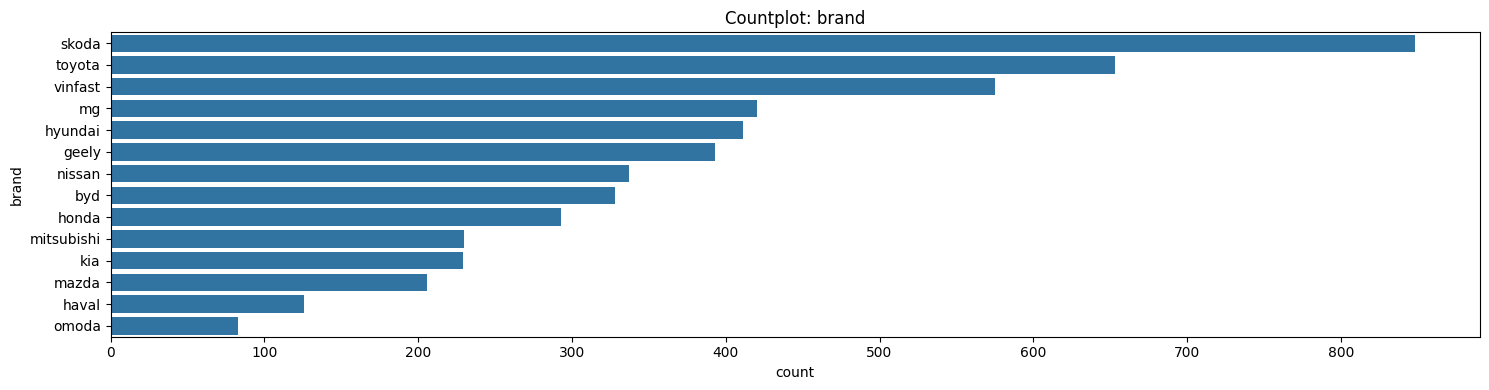

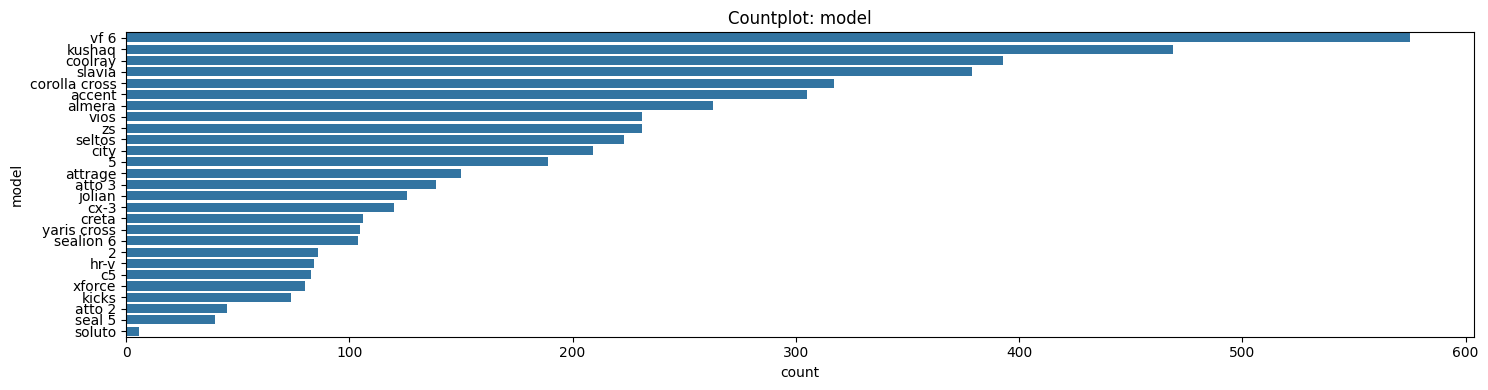

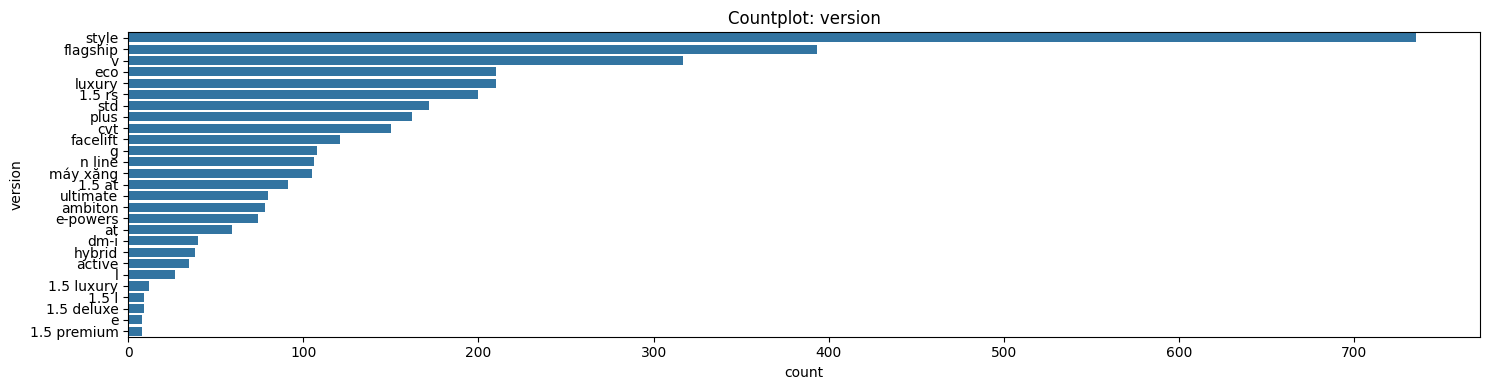

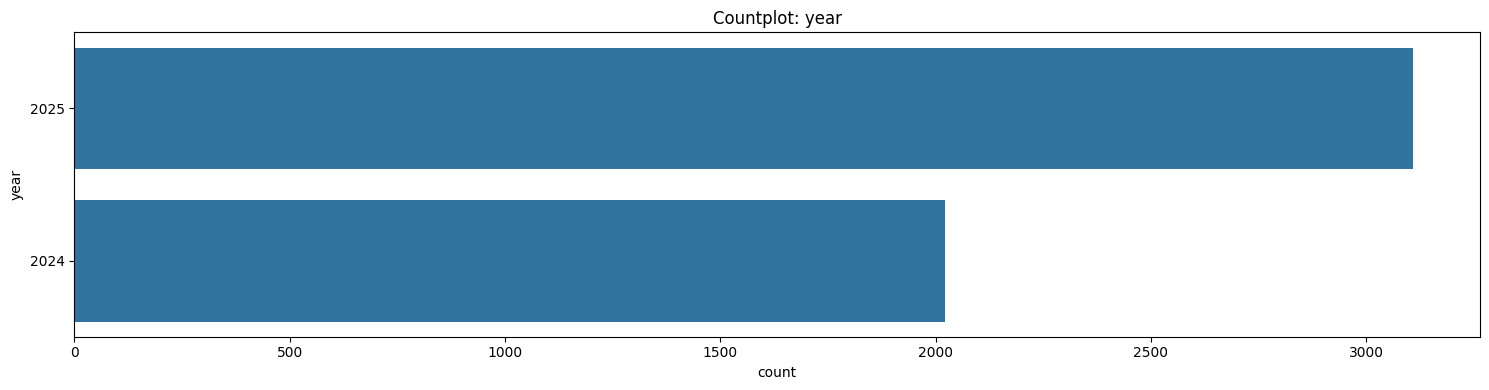

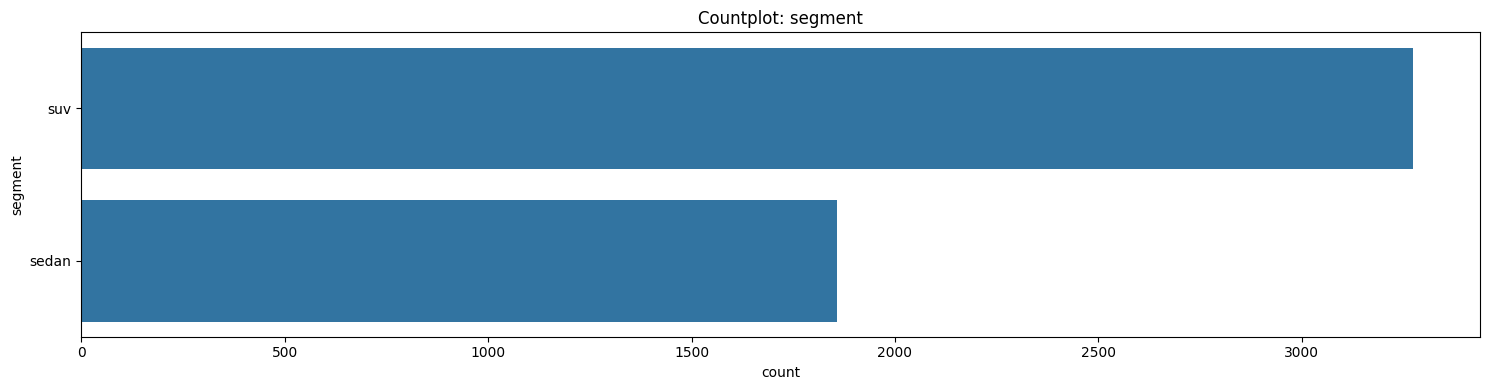

In [9]:
for col in df.columns[:-2]:
    counts = df[col].value_counts()
    plt.figure(figsize=(15, 4))
    sns.countplot(y=col, data=df, order=counts.index)
    plt.title(f"Countplot: {col}")
    plt.tight_layout()
    plt.show()

---

## Labels

In [10]:
df_label = df[["comment", "label"]].copy()

In [11]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5132 entries, 0 to 5131
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  5132 non-null   object
 1   label    5132 non-null   object
dtypes: object(2)
memory usage: 80.3+ KB


In [12]:
df_label.head()

,comment,label
0,Giá nó còn quá cao so vs thu nhập ng Việ...,negative
1,"Kushaq có Apple CarPlay không dây, kết nối tiệ...",positive
2,Mua xe cứ theo tôn chỉ: Tiền nào của nấy,neutral
3,"xe quá đỉnh , chuẩn xe châu âu giá cả phải chăng",positive
4,715 nline lăn bánh gần 800 thì Terri trend + C...,negative


In [13]:
label_counts = df[["label"]].value_counts()
total_labels = df["label"].nunique()

In [14]:
print(f"Total labels: {total_labels}")

Total labels: 3


In [15]:
print(f"Unique labels: {label_counts.index.tolist()}")

Unique labels: [('positive',), ('negative',), ('neutral',)]


In [16]:
label_counts

label   
positive    2589
negative    2023
neutral      520
Name: count, dtype: int64

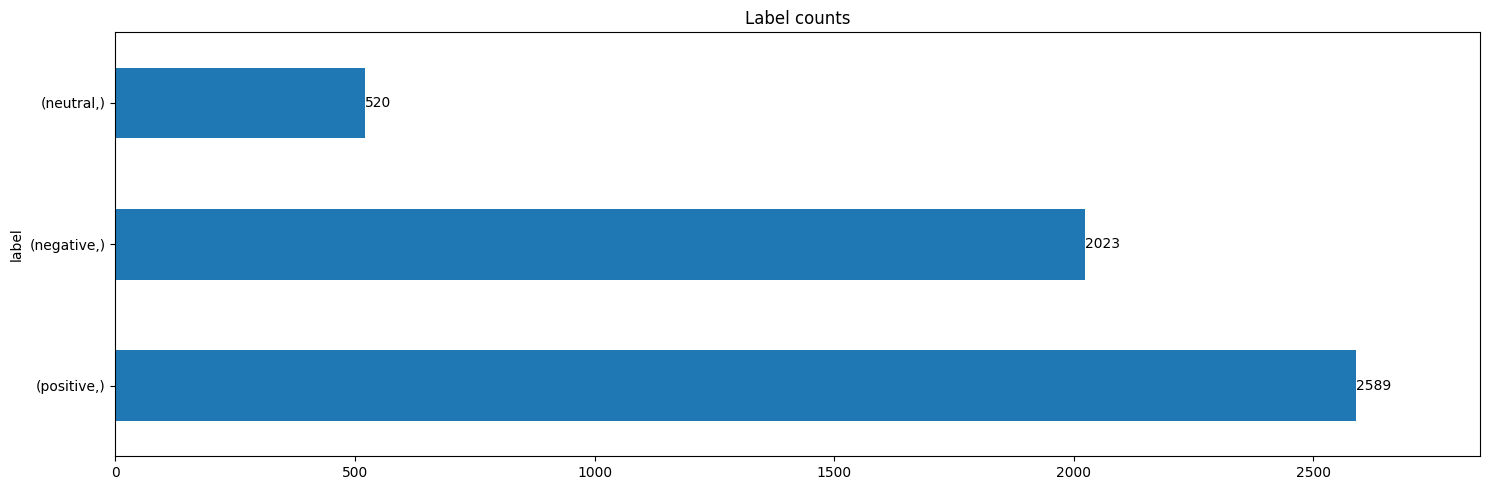

In [17]:
ax = label_counts.plot(kind='barh', figsize=(15,5), title='Label counts')
max_width = int(label_counts.max())
for p in ax.patches:
    value = int(p.get_width())
    y = p.get_y() + p.get_height() / 2
    x = p.get_x() + p.get_width() + 0.3
    ax.text(x, y, str(value), va='center', ha='left', fontsize=10)
ax.set_xlim(0, max_width * 1.10) 
plt.tight_layout()
plt.show()